In [ ]:
!pip install -q -U tensorflow-text==2.7.3

     |████████████████████████████████| 4.9 MB 5.6 MB/s 
     |████████████████████████████████| 495.0 MB 32 kB/s 
     |████████████████████████████████| 463 kB 48.6 MB/s 
     |████████████████████████████████| 1.3 MB 43.8 MB/s 


In [ ]:
!pip install -q -U tf-models-official==2.7.0

     |████████████████████████████████| 1.8 MB 5.1 MB/s 
     |████████████████████████████████| 234 kB 55.1 MB/s 
     |████████████████████████████████| 99 kB 7.3 MB/s 
     |████████████████████████████████| 43 kB 1.7 MB/s 
     |████████████████████████████████| 352 kB 45.4 MB/s 
     |████████████████████████████████| 1.1 MB 42.0 MB/s 
     |████████████████████████████████| 47.7 MB 1.3 MB/s 
     |████████████████████████████████| 90 kB 9.0 MB/s 
     |████████████████████████████████| 1.2 MB 47.7 MB/s 
     |████████████████████████████████| 596 kB 54.2 MB/s 


In [ ]:
!pip install -U tfds-nightly==4.3.0.dev202107180106

     |████████████████████████████████| 4.0 MB 5.3 MB/s 


In [ ]:
import os
import tensorflow as tf
import tensorflow_hub as hub
import tensorflow_datasets as tfds
import tensorflow_text as text
import tensorflow_addons as tfa
from official.nlp import optimization
import numpy as np

tf.get_logger().setLevel('ERROR')

In [ ]:
print(tf.__version__)

2.7.1


In [ ]:
os.environ["TFHUB_MODEL_LOAD_FORMAT"]="UNCOMPRESSED"

In [ ]:
import os

if os.environ['COLAB_TPU_ADDR']:
  cluster_resolver = tf.distribute.cluster_resolver.TPUClusterResolver(tpu='')
  tf.config.experimental_connect_to_cluster(cluster_resolver)
  tf.tpu.experimental.initialize_tpu_system(cluster_resolver)
  strategy = tf.distribute.TPUStrategy(cluster_resolver)
  print('Using TPU')
elif tf.config.list_physical_devices('GPU'):
  strategy = tf.distribute.MirroredStrategy()
  print('Using GPU')
else:
  raise ValueError('Running on CPU. Will take too much time.')

Using TPU


In [ ]:
tfhub_handle_encoder = 'https://tfhub.dev/tensorflow/bert_en_uncased_L-12_H-768_A-12/3'
tfhub_handle_preprocess = 'https://tfhub.dev/tensorflow/bert_en_uncased_preprocess/3'

In [ ]:
def make_bert_preprocess_model(sentence_features, seq_length=128):
  """Returns Model mapping string features to BERT inputs.

  Args:
    sentence_features: a list with the names of string-valued features.
    seq_length: an integer that defines the sequence length of BERT inputs.

  Returns:
    A Keras Model that can be called on a list or dict of string Tensors
    (with the order or names, resp., given by sentence_features) and
    returns a dict of tensors for input to BERT.
  """

  input_segments = [
      tf.keras.layers.Input(shape=(), dtype=tf.string, name=ft)
      for ft in sentence_features]

  # Tokenize the text to word pieces.
  bert_preprocess = hub.load(tfhub_handle_preprocess)
  tokenizer = hub.KerasLayer(bert_preprocess.tokenize, name='tokenizer')
  segments = [tokenizer(s) for s in input_segments]

  # Optional: Trim segments in a smart way to fit seq_length.
  # Simple cases (like this example) can skip this step and let
  # the next step apply a default truncation to approximately equal lengths.
  truncated_segments = segments

  # Pack inputs. The details (start/end token ids, dict of output tensors)
  # are model-dependent, so this gets loaded from the SavedModel.
  packer = hub.KerasLayer(bert_preprocess.bert_pack_inputs,
                          arguments=dict(seq_length=seq_length),
                          name='packer')
  model_inputs = packer(truncated_segments)
  return tf.keras.Model(input_segments, model_inputs)

In [ ]:
test_preprocess_model = make_bert_preprocess_model(['input_1', 'input_2'])
test_text = [np.array(['Dr. Dhirendra Kumar Sharma is a professor at UPES']),
             np.array(['Dr. Chandan Sharma is also a professor at UPES'])]
text_preprocessed = test_preprocess_model(test_text)

print('Keys           : ', list(text_preprocessed.keys()))
print('Shape Word Ids : ', text_preprocessed['input_word_ids'].shape)
print('Word Ids       : ', text_preprocessed['input_word_ids'][0, :16])
print('Shape Mask     : ', text_preprocessed['input_mask'].shape)
print('Input Mask     : ', text_preprocessed['input_mask'][0, :16])
print('Shape Type Ids : ', text_preprocessed['input_type_ids'].shape)
print('Type Ids       : ', text_preprocessed['input_type_ids'][0, :16])

Keys           :  ['input_word_ids', 'input_type_ids', 'input_mask']
Shape Word Ids :  (1, 128)
Word Ids       :  tf.Tensor(
[  101  2852  1012 28144  7442 17670  9600 14654  2003  1037  2934  2012
  2039  2229   102  2852], shape=(16,), dtype=int32)
Shape Mask     :  (1, 128)
Input Mask     :  tf.Tensor([1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1], shape=(16,), dtype=int32)
Shape Type Ids :  (1, 128)
Type Ids       :  tf.Tensor([0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1], shape=(16,), dtype=int32)


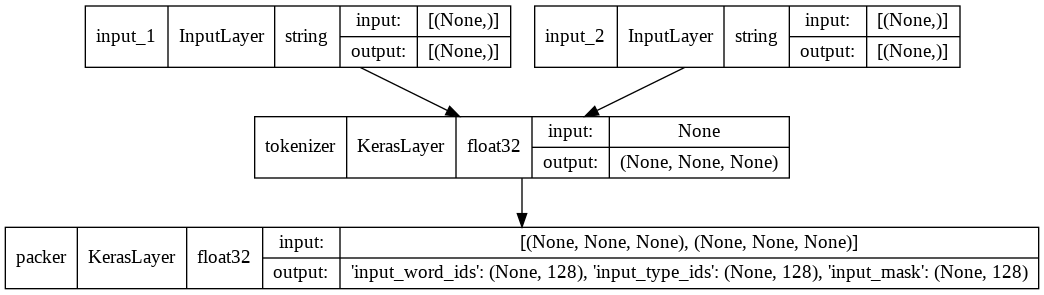

In [ ]:
tf.keras.utils.plot_model(test_preprocess_model, show_shapes=True, show_dtype=True)

In [ ]:
AUTOTUNE = tf.data.AUTOTUNE


def load_dataset_from_tfds(in_memory_ds, info, split, batch_size,
                           bert_preprocess_model):
  is_training = split.startswith('train')
  dataset = tf.data.Dataset.from_tensor_slices(in_memory_ds[split])
  num_examples = info.splits[split].num_examples

  if is_training:
    dataset = dataset.shuffle(num_examples)
    dataset = dataset.repeat()
  dataset = dataset.batch(batch_size)
  dataset = dataset.map(lambda ex: (bert_preprocess_model(ex), ex['label']))
  dataset = dataset.cache().prefetch(buffer_size=AUTOTUNE)
  return dataset, num_examples

## Defining the model

In [ ]:
def build_classifier_model(num_classes):

  class Classifier(tf.keras.Model):
    def __init__(self, num_classes):
      super(Classifier, self).__init__(name="prediction")
      self.encoder = hub.KerasLayer(tfhub_handle_encoder, trainable=True)
      self.dropout = tf.keras.layers.Dropout(0.1)
      self.dense = tf.keras.layers.Dense(num_classes)

    def call(self, preprocessed_text):
      encoder_outputs = self.encoder(preprocessed_text)
      pooled_output = encoder_outputs["pooled_output"]
      x = self.dropout(pooled_output)
      x = self.dense(x)
      return x

  model = Classifier(num_classes)
  return model

testing the model on preprocessed inputs.

In [ ]:
test_classifier_model = build_classifier_model(2)
bert_raw_result = test_classifier_model(text_preprocessed)
print(tf.sigmoid(bert_raw_result))

tf.Tensor([[0.5029355 0.906154 ]], shape=(1, 2), dtype=float32)


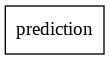

In [ ]:
tf.keras.utils.plot_model(test_classifier_model, show_shapes=True, show_dtype=True)

## Choose a task from GLUE

You are going to use a TensorFlow DataSet from the [GLUE](https://www.tensorflow.org/datasets/catalog/glue) benchmark suite.

Colab lets you download these small datasets to the local filesystem, and the code below reads them entirely into memory, because the separate TPU worker host cannot access the local filesystem of the colab runtime.

For bigger datasets, you'll need to create your own [Google Cloud Storage](https://cloud.google.com/storage) bucket and have the TPU worker read the data from there. You can learn more in the [TPU guide](https://www.tensorflow.org/guide/tpu#input_datasets).

It's recommended to start with the CoLa dataset (for single sentence) or MRPC (for multi sentence) since these are small and don't take long to fine tune.

In [ ]:
tfds_name = 'glue/cola'

tfds_info = tfds.builder(tfds_name).info

sentence_features = list(tfds_info.features.keys())
sentence_features.remove('idx')
sentence_features.remove('label')

available_splits = list(tfds_info.splits.keys())
train_split = 'train'
validation_split = 'validation'
test_split = 'test'
if tfds_name == 'glue/mnli':
  validation_split = 'validation_matched'
  test_split = 'test_matched'

num_classes = tfds_info.features['label'].num_classes
num_examples = tfds_info.splits.total_num_examples

print(f'Using {tfds_name} from TFDS')
print(f'This dataset has {num_examples} examples')
print(f'Number of classes: {num_classes}')
print(f'Features {sentence_features}')
print(f'Splits {available_splits}')

with tf.device('/job:localhost'):
  # batch_size=-1 is a way to load the dataset into memory
  in_memory_ds = tfds.load(tfds_name, batch_size=-1, shuffle_files=True)

# The code below is just to show some samples from the selected dataset
print(f'Here are some sample rows from {tfds_name} dataset')
sample_dataset = tf.data.Dataset.from_tensor_slices(in_memory_ds[train_split])

labels_names = tfds_info.features['label'].names
print(labels_names)
print()

sample_i = 1
for sample_row in sample_dataset.take(10):
  samples = [sample_row[feature] for feature in sentence_features]
  print(f'sample row {sample_i}')
  for sample in samples:
    print(sample.numpy())
  sample_label = sample_row['label']

  print(f'label: {sample_label} ({labels_names[sample_label]})')
  print()
  sample_i += 1

Using glue/cola from TFDS
This dataset has 10657 examples
Number of classes: 2
Features ['sentence']
Splits ['train', 'validation', 'test']


Dl Completed...: 0 url [00:00, ? url/s]

Dl Size...: 0 MiB [00:00, ? MiB/s]

Extraction completed...: 0 file [00:00, ? file/s]

Generating splits...:   0%|          | 0/3 [00:00<?, ? splits/s]

Generating train examples...:   0%|          | 0/8551 [00:00<?, ? examples/s]

Shuffling glue-train.tfrecord...:   0%|          | 0/8551 [00:00<?, ? examples/s]

Generating validation examples...:   0%|          | 0/1043 [00:00<?, ? examples/s]

Shuffling glue-validation.tfrecord...:   0%|          | 0/1043 [00:00<?, ? examples/s]

Generating test examples...:   0%|          | 0/1063 [00:00<?, ? examples/s]

Shuffling glue-test.tfrecord...:   0%|          | 0/1063 [00:00<?, ? examples/s]

Dataset glue downloaded and prepared to /root/tensorflow_datasets/glue/cola/2.0.0. Subsequent calls will reuse this data.
Here are some sample rows from glue/cola dataset
['unacceptable', 'acceptable']

sample row 1
b'It is this hat that it is certain that he was wearing.'
label: 1 (acceptable)

sample row 2
b'Her efficient looking up of the answer pleased the boss.'
label: 1 (acceptable)

sample row 3
b'Both the workers will wear carnations.'
label: 1 (acceptable)

sample row 4
b'John enjoyed drawing trees for his syntax homework.'
label: 1 (acceptable)

sample row 5
b'We consider Leslie rather foolish, and Lou a complete idiot.'
label: 1 (acceptable)

sample row 6
b'The inspector analyzed the soundness in the building.'
label: 0 (unacceptable)

sample row 7
b'I broke the twig off the branch.'
label: 1 (acceptable)

sample row 8
b"I didn't help him because I have any sympathy for urban guerillas."
label: 1 (acceptable)

sample row 9
b'Bill will put a picture of her on your desk before

The dataset also determines the problem type (classification or regression) and the appropriate loss function for training.

In [ ]:
def get_configuration(glue_task):

  loss = tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True)

#   metrics = tfa.metrics.MatthewsCorrelationCoefficient(num_classes=2)
  metrics = tf.keras.metrics.SparseCategoricalAccuracy(
        'accuracy', dtype=tf.float32)


  return metrics, loss

## Train your model

In [ ]:
epochs = 3
batch_size = 32
init_lr = 2e-5

print(f'Fine tuning {tfhub_handle_encoder} model')
bert_preprocess_model = make_bert_preprocess_model(sentence_features)

with strategy.scope():

  # metric have to be created inside the strategy scope
  metrics, loss = get_configuration(tfds_name)

  train_dataset, train_data_size = load_dataset_from_tfds(
      in_memory_ds, tfds_info, train_split, batch_size, bert_preprocess_model)
  steps_per_epoch = train_data_size // batch_size
  num_train_steps = steps_per_epoch * epochs
  num_warmup_steps = num_train_steps // 10

  validation_dataset, validation_data_size = load_dataset_from_tfds(
      in_memory_ds, tfds_info, validation_split, batch_size,
      bert_preprocess_model)
  validation_steps = validation_data_size // batch_size

  classifier_model = build_classifier_model(num_classes)

  optimizer = optimization.create_optimizer(
      init_lr=init_lr,
      num_train_steps=num_train_steps,
      num_warmup_steps=num_warmup_steps,
      optimizer_type='adamw')

  classifier_model.compile(optimizer=optimizer, loss=loss, metrics=[metrics])

  history = classifier_model.fit(
      x=train_dataset,
      validation_data=validation_dataset,
      steps_per_epoch=steps_per_epoch,
      epochs=epochs,
      validation_steps=validation_steps)

Fine tuning https://tfhub.dev/tensorflow/bert_en_uncased_L-12_H-768_A-12/3 model


/usr/local/lib/python3.7/dist-packages/keras/engine/functional.py:559: UserWarning: Input dict contained keys ['idx', 'label'] which did not match any model input. They will be ignored by the model.
  inputs = self._flatten_to_reference_inputs(inputs)


Epoch 1/3


/usr/local/lib/python3.7/dist-packages/tensorflow/python/framework/indexed_slices.py:450: UserWarning: Converting sparse IndexedSlices(IndexedSlices(indices=Tensor("AdamWeightDecay/gradients/StatefulPartitionedCall:1", shape=(None,), dtype=int32), values=Tensor("clip_by_global_norm/clip_by_global_norm/_0:0", dtype=float32), dense_shape=Tensor("AdamWeightDecay/gradients/StatefulPartitionedCall:2", shape=(None,), dtype=int32))) to a dense Tensor of unknown shape. This may consume a large amount of memory.
  "shape. This may consume a large amount of memory." % value)


267/267 [==============================] - 103s 107ms/step - loss: 0.5638 - accuracy: 0.7261 - val_loss: 0.5782 - val_accuracy: 0.7891
Epoch 2/3
267/267 [==============================] - 23s 85ms/step - loss: 0.3551 - accuracy: 0.8674 - val_loss: 0.5661 - val_accuracy: 0.8184
Epoch 3/3
267/267 [==============================] - 24s 89ms/step - loss: 0.2502 - accuracy: 0.9187 - val_loss: 0.5878 - val_accuracy: 0.8311


In [ ]:
test_dataset, test_data_size = load_dataset_from_tfds(
      in_memory_ds, tfds_info, test_split, batch_size, bert_preprocess_model)

/usr/local/lib/python3.7/dist-packages/keras/engine/functional.py:559: UserWarning: Input dict contained keys ['idx', 'label'] which did not match any model input. They will be ignored by the model.
  inputs = self._flatten_to_reference_inputs(inputs)


In [ ]:
history.history

{'accuracy': [0.7261236310005188, 0.8673923015594482, 0.9186563491821289],
 'loss': [0.5638477206230164, 0.3550751507282257, 0.25015464425086975],
 'val_accuracy': [0.7890625, 0.818359375, 0.8310546875],
 'val_loss': [0.5781980156898499, 0.566132128238678, 0.5877501964569092]}

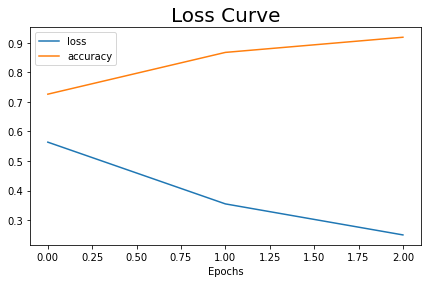

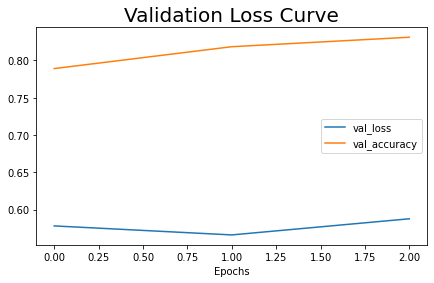

In [ ]:
import pandas as pd
import matplotlib.pyplot as plt

df = pd.DataFrame(history.history)

# Creating a plot for loss and accuracy
plt.figure(figsize=(7,4))
plt.plot(df['loss'])
plt.plot(df['accuracy'])
plt.legend(['loss', 'accuracy'])
plt.title("Loss Curve", fontdict={'fontsize':20})
plt.xlabel("Epochs")
plt.show();

# Creating a plot for validation loss and validation accuracy
plt.figure(figsize=(7,4))
plt.plot(df['val_loss'])
plt.plot(df['val_accuracy'])
plt.legend(['val_loss', 'val_accuracy'])
plt.title("Validation Loss Curve", fontdict={'fontsize':20})
plt.xlabel("Epochs")
plt.show();

## Export for inference


In [ ]:
main_save_path = './my_models'
bert_type = tfhub_handle_encoder.split('/')[-2]
saved_model_name = f'{tfds_name.replace("/", "_")}_{bert_type}'

saved_model_path = os.path.join(main_save_path, saved_model_name)

preprocess_inputs = bert_preprocess_model.inputs
bert_encoder_inputs = bert_preprocess_model(preprocess_inputs)
bert_outputs = classifier_model(bert_encoder_inputs)
model_for_export = tf.keras.Model(preprocess_inputs, bert_outputs)

print('Saving', saved_model_path)

# Save everything on the Colab host (even the variables from TPU memory)
save_options = tf.saved_model.SaveOptions(experimental_io_device='/job:localhost')
model_for_export.save(saved_model_path, include_optimizer=False,
                      options=save_options)

Saving ./my_models/glue_cola_bert_en_uncased_L-12_H-768_A-12


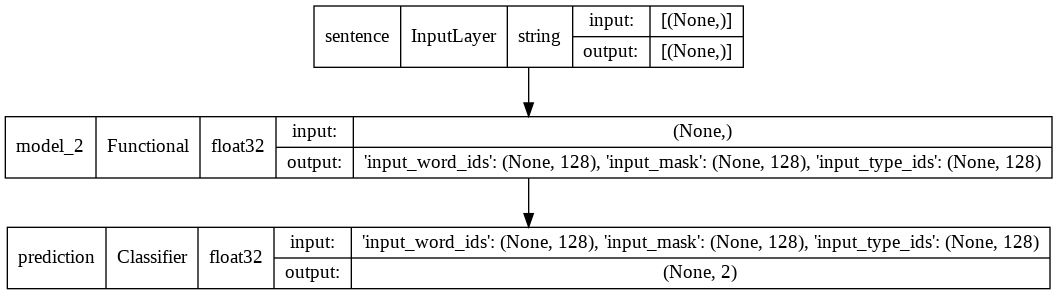

In [ ]:
tf.keras.utils.plot_model(model_for_export, show_shapes=True, show_dtype=True)

In [ ]:
classifier_model.evaluate(test_dataset)

34/34 [==============================] - 8s 156ms/step - loss: nan - accuracy: 0.0000e+00


[nan, 0.0]

In [ ]:
pred = classifier_model.predict(test_dataset)

In [ ]:
pred

array([[-2.5318508 ,  2.4465222 ],
       [-1.7683195 ,  2.3670735 ],
       [-3.4009986 ,  0.33369252],
       ...,
       [ 0.4129092 ,  0.38978136],
       [-3.5381517 ,  0.9144973 ],
       [-3.4284704 ,  1.9166296 ]], dtype=float32)

## Test the model


In [ ]:
with tf.device('/job:localhost'):
  reloaded_model = tf.saved_model.load(saved_model_path)

In [ ]:
# Utility methods

def prepare(record):
  model_inputs = [[record[ft]] for ft in sentence_features]
  return model_inputs


def prepare_serving(record):
  model_inputs = {ft: record[ft] for ft in sentence_features}
  return model_inputs


def print_bert_results(test, bert_result, dataset_name):

  bert_result_class = tf.argmax(bert_result, axis=1)[0]

  print('sentence:', test[0].numpy())
  if bert_result_class == 1:
    print('This sentence is acceptable')
  else:
    print('This sentence is unacceptable')



  print('BERT raw results:', bert_result[0])
  print()

### Test

In [ ]:
def load_dataset_from_tfds_2(in_memory_ds, info, split, batch_size,
                           bert_preprocess_model):

  dataset = tf.data.Dataset.from_tensor_slices(in_memory_ds[split])
  num_examples = info.splits[split].num_examples

  dataset = dataset.batch(batch_size)
  
  dataset = dataset.cache().prefetch(buffer_size=AUTOTUNE)
  return dataset, num_examples

v_dataset, v_data_size = load_dataset_from_tfds_2(
      in_memory_ds, tfds_info, validation_split, batch_size,
      bert_preprocess_model)

In [ ]:
v_dataset_2 = v_dataset.map(lambda ex: (bert_preprocess_model(ex), ex['label']))

/usr/local/lib/python3.7/dist-packages/keras/engine/functional.py:559: UserWarning: Input dict contained keys ['idx', 'label'] which did not match any model input. They will be ignored by the model.
  inputs = self._flatten_to_reference_inputs(inputs)


In [ ]:
ar = []
pr = []

with tf.device('/job:localhost'):

    test_dataset = tf.data.Dataset.from_tensor_slices(in_memory_ds[validation_split])
    for test_row in test_dataset:
        ar.append(test_row['label'].numpy())
        pr.append(tf.argmax(reloaded_model(tf.reshape(test_row['sentence'], (1,))), axis=1)[0].numpy())

In [ ]:
from sklearn.metrics import confusion_matrix
confusion_matrix(ar, pr)

array([[175, 147],
       [ 41, 680]])

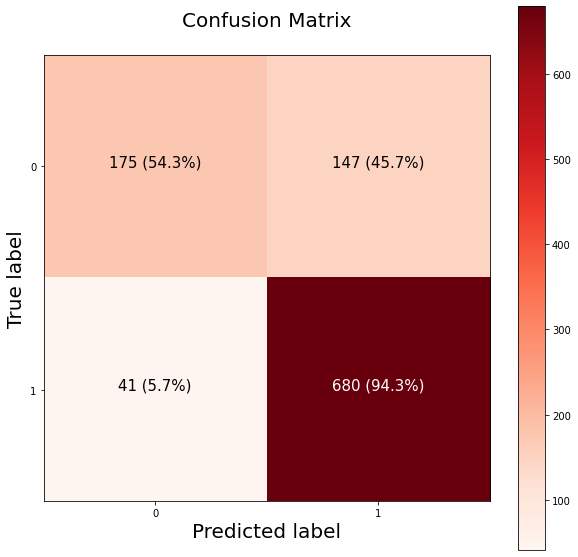

In [ ]:
from sklearn.metrics import confusion_matrix
import itertools


figsize = (10, 10)
# Create the confusion matrix
cm = confusion_matrix(ar, pr)
cm_norm = cm.astype("float") / cm.sum(axis=1)[:, np.newaxis] # normalize it
n_classes = cm.shape[0]

# Let's prettify it
fig, ax = plt.subplots(figsize=figsize)
# Create a matrix plot
cax = ax.matshow(cm, cmap=plt.cm.Reds)
fig.colorbar(cax)

# Create classes
classes = False

if classes:
  labels = classes
else:
  labels = np.arange(cm.shape[0])

# Label the axes
ax.set(title="Confusion Matrix",
       xlabel="Predicted label",
       ylabel="True label",
       xticks=np.arange(n_classes),
       yticks=np.arange(n_classes),
       xticklabels=labels,
       yticklabels=labels)

# Set x-axis labels to bottom
ax.xaxis.set_label_position("bottom")
ax.xaxis.tick_bottom()

# Adjust label size
ax.xaxis.label.set_size(20)
ax.yaxis.label.set_size(20)
ax.title.set_size(20)

# Set threshold for different colors
threshold = (cm.max() + cm.min()) / 2.

# Plot the text on each cell
for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
  plt.text(j, i, f"{cm[i, j]} ({cm_norm[i, j]*100:.1f}%)",
           horizontalalignment="center",
           color="white" if cm[i, j] > threshold else "black",
           size=15)


In [ ]:
with tf.device('/job:localhost'):

    false_pred = []

    test_dataset = tf.data.Dataset.from_tensor_slices(in_memory_ds[validation_split])
    i = 0
    for test_row in test_dataset:
        if ar[i] != pr[i]:
            false_pred.append({'id': i,
                               'actual_label': ar[i],
                               'predicted_label': pr[i],
                               'sentence': test_row['sentence'].numpy()})
        i = i+1

In [ ]:
for fp in false_pred:
    if fp['actual_label']==0:
        print()
        print(fp['sentence'])


b'Mary revealed himself to John.'

b"I know that Meg's attracted to Harry, but they don't know who."

b"She doesn't meet anyone for dinner, but they can't figure out who."

b'Did the child be in the school?'

b'What did you ask who Medea gave?'

b'Which king did you ask which city invaded?'

b'What they feared most was to be no one available to help them.'

b"John was tall, but I don't know on what occasions."

b'Mary wonders that Bill will come.'

b'Jack is the person with whom Jenny fell in love with.'

b"She said she talked to three students but I don't know how many."

b"Gould's performance of Bach on the piano doesn't please me anywhere as much as Ross's on the harpsichord."

b'The book that I like - everyone else in the class hates.'

b'Did Calvin his homework?'

b"Tony sent Mo a picture that he painted, but it's not clear with what."

b'Kim depends for Sandy.'

b'Was sunk.'

b'In which way is Sandy very anxious to see if the students will be able to solve the homework problem?'

On random data (without labels)

In [ ]:
with tf.device('/job:localhost'):
  test_dataset = tf.data.Dataset.from_tensor_slices(in_memory_ds[test_split])
  for test_row in test_dataset.shuffle(1000).map(prepare).take(10):
    if len(sentence_features) == 1:
      result = reloaded_model(test_row[0])
    else:
      result = reloaded_model(list(test_row))

    print_bert_results(test_row, result, tfds_name)

sentence: [b'Herman whipped the sugar and the cream together.']
This sentence is acceptable
BERT raw results: tf.Tensor([-2.6593633  3.3283498], shape=(2,), dtype=float32)

sentence: [b'I think that who went home.']
This sentence is unacceptable
BERT raw results: tf.Tensor([ 0.77184033 -2.6131895 ], shape=(2,), dtype=float32)

sentence: [b'She voted for her.']
This sentence is acceptable
BERT raw results: tf.Tensor([-1.9764107  2.7914367], shape=(2,), dtype=float32)

sentence: [b'Kerry remarked the time.']
This sentence is unacceptable
BERT raw results: tf.Tensor([ 0.81557286 -2.503622  ], shape=(2,), dtype=float32)

sentence: [b"I can't believe Holly won't eat cabbage."]
This sentence is acceptable
BERT raw results: tf.Tensor([-1.1798817  2.4223182], shape=(2,), dtype=float32)

sentence: [b'Dana learned the umbrella was broken.']
This sentence is acceptable
BERT raw results: tf.Tensor([-2.357637   3.1311858], shape=(2,), dtype=float32)

sentence: [b'I want Bob to shave himself, and Ma

In [ ]:
with tf.device('/job:localhost'):
  serving_model = reloaded_model.signatures['serving_default']
  for test_row in test_dataset.shuffle(1000).map(prepare_serving).take(10):
    result = serving_model(**test_row)
    # The 'prediction' key is the classifier's defined model name.
    print_bert_results(list(test_row.values()), result['prediction'], tfds_name)

sentence: b"I like Bill's new wine, but Max's old is even better."
This sentence is acceptable
BERT raw results: tf.Tensor([-3.2132447  3.6257834], shape=(2,), dtype=float32)

sentence: b"She served the soup, but I don't know to whom."
This sentence is acceptable
BERT raw results: tf.Tensor([-3.500081   3.0621607], shape=(2,), dtype=float32)

sentence: b'It was Mary.'
This sentence is acceptable
BERT raw results: tf.Tensor([-4.854866   4.6311107], shape=(2,), dtype=float32)

sentence: b'It is believed to be the problem that he is here.'
This sentence is unacceptable
BERT raw results: tf.Tensor([ 3.0769825 -3.7311811], shape=(2,), dtype=float32)

sentence: b'This meat cuts itself.'
This sentence is acceptable
BERT raw results: tf.Tensor([-4.518653   3.8287919], shape=(2,), dtype=float32)

sentence: b'Packages carry easily.'
This sentence is unacceptable
BERT raw results: tf.Tensor([ 4.1503644 -4.5915656], shape=(2,), dtype=float32)

sentence: b'Joan offered, and Mary actually gave, a go

Saved model could be used for serving or simple inference in a process, with a simpler api with less code and easier to maintain.
